# EMRI Waveforms in Fourier Domain
Here we present the usage of the EMRI Waveforms in Fourier Domain. Currently we implemented the Fourier Domain Waveform only for the Schawrzchild case.

In [66]:
import sys, time, h5py,os

import matplotlib
import scienceplots
import numpy as np
import matplotlib.pyplot as plt

# import or install these packages for the data anlysis of the resultss
sys.path.append("../LISAanalysistools/")
sys.path.append("../Eryn/")

import corner
from lisatools.sampling.likelihood import Likelihood
from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.utility import get_mu_at_t
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="SchwarzEccFlux")
omp_set_num_threads(1)
from few.utils.utility import cuda_set_device

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from FDutils import *

try:
    import cupy as xp
    # set GPU device
    os.system(f"CUDA_VISIBLE_DEVICES=0")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    use_gpu = True

except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    use_gpu = False

import warnings
warnings.filterwarnings("ignore")


few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd",odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True,odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

default_width = 5.78853 # in inches
default_ratio = (np.sqrt(5.0) - 1.0) / 2.0 # golden mean
figsize_std=(default_width,default_width * default_ratio)

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    if m!='1':
        return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
    else:
        return r'10^{{{e:d}}}'.format(e=int(e))


def get_colorplot(data, color_value, label, label_cbar):
    colors = color_value
    n_dimensions = data.shape[-1]
    # Plot the corner plot
    figure, axes = plt.subplots(n_dimensions-1, n_dimensions-1, figsize=(10, 10))

    # Custom color map
    cmap = plt.cm.get_cmap('seismic')  # Choose a color map of your preference

    for i in range(n_dimensions-1):
        for j in range(n_dimensions-1):
            if j < i:
                axes[j, i].axis('off')
            else:
                axes[j, i].scatter(data[:, i], data[:, j+1], c=colors, cmap=cmap, s=5,alpha=0.6)
                

    [axes[n_dimensions-2, i].set_xlabel(label[i]) for i in range(n_dimensions-1)]
    [axes[n_dimensions-2, i].set_yticklabels([]) for i in range(1,n_dimensions-1)]
    [axes[j, 0].set_ylabel(label[j+1]) for j in range(n_dimensions-1)]
    [axes[j, 0].set_xticklabels([]) for j in range(n_dimensions-2)]

    # Customize color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(colors), vmax=np.max(colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), anchor=(0.0,11.0), orientation='horizontal')
    cbar.set_label(label_cbar, rotation=0, labelpad=15)

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()



In [70]:
# define the injection parameters
# M = 1e6 # central object mass
# a = 0.1  # will be ignored in Schwarzschild waveform
# mu = 10.0 # secondary object mass
# p0 = 12.0 # initial semi-latus rectum
# e0 = 0.6 # eccentricity

M = 2e4#8019425.9054786945 # central object mass
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 1.0#685.1946995167503 # secondary object mass
p0 = 12.115436197262476 # initial semi-latus rectum
e0 = 0.39141517457483055  # eccentricity

x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = np.pi/3
Phi_theta0 = 0.0
Phi_r0 = np.pi/3

Tobs = 4.0 # observation time, if the inspiral is shorter, the it will be zero padded 
dt = 1.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,2,0)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following ling if you want to show a mode
#     "mode_selection" : mode_selection,
#     "include_minus_m": True
    "eps": eps,
    
}


# p0 = get_p_at_t(
# traj_module,
# Tobs*0.99,
# [M, mu, 0.0, e0, 1.0],
# index_of_p=3,
# index_of_a=2,
# index_of_e=4,
# index_of_x=5,
# traj_kwargs={},
# xtol=2e-12,
# rtol=8.881784197001252e-16,
# bounds=None,
# )


emri_injection_params = [
                            M,  
                            mu,
                            a, 
                            p0, 
                            e0, 
                            x0,
                            dist, 
                            qS,
                            phiS,
                            qK, 
                            phiK, 
                            Phi_phi0, 
                            Phi_theta0, 
                            Phi_r0
                        ]

## Comparison against the Time Domain Waveforms

In [71]:
# create TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)
# window = xp.asarray(tukey(len(data_channels_td[0]),0.5))
# data_channels_td = [data_channels_td[0]*window, data_channels_td[1]*window,]

# take the FFT of the plus polarization and shift it
fft_TD = xp.fft.fftshift(xp.fft.fft(data_channels_td[0])) * dt
freq = xp.fft.fftshift(xp.fft.fftfreq(len(data_channels_td[0]) , dt))

# define the positive frequencies
positive_frequency_mask = (freq>=0.0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


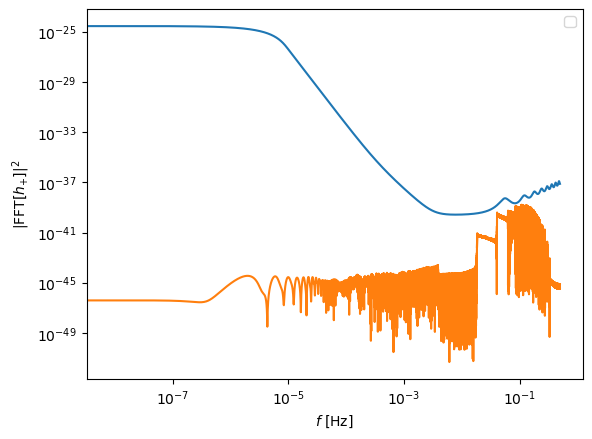

In [72]:

plt.figure()
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), get_sensitivity(freq[positive_frequency_mask].get()))
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2)
else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2)
    plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]))
plt.ylabel(r'$| {\rm FFT} [h_{+}]|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

In [58]:
# check that the frequency array is an odd number
len(freq)

609821

In [59]:
# you can specify the frequencies or obtain them directly from the waveform
fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq
fd_kwargs['mask_positive']=True

hf = few_gen(*emri_injection_params,**fd_kwargs)
# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency

# mask where the FD waveform is non zero
non_zero_mask = (xp.abs(hf[0])>1e-50)

# mismatch
fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask])
Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask], hf[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)
Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask][non_zero_mask], hf[0][non_zero_mask], normalize=True, 
                **dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask][non_zero_mask])))
print("mismatch", Mism)


mismatch 0.002099965734531084
mismatch 0.0020989137632544397


In [60]:
# fmax = 0.5 * 1/dt
0.5/np.min(freq[positive_frequency_mask][~non_zero_mask])

array(207.43506118)

In [61]:
fft_td_gen = get_fd_waveform_fromTD(td_gen, positive_frequency_mask, dt, non_zero_mask=non_zero_mask)
sig_td = fft_td_gen(*emri_injection_params,**fd_kwargs)
diff_h = [hf[0] - sig_td[0], hf[1] - sig_td[1]]
Mism = -0.5*inner_product(diff_h, diff_h, normalize=False, **dict(PSD=xp.asarray(get_sensitivity(freq[positive_frequency_mask].get())), use_gpu=use_gpu, f_arr=freq[positive_frequency_mask]))
print(Mism)

-44.37635182681751


In [62]:
# sig_td_windowed = [el[positive_frequency_mask] for el in get_fft_td_windowed(data_channels_td, window, dt)]

fd_kwargs2 = fd_kwargs.copy()
del fd_kwargs2['eps']
fd_kwargs2['mode_selection'] = [(2,2,0)]
hf_220 = few_gen(*emri_injection_params,**fd_kwargs2)
# sig_fd_windowed = [el[positive_frequency_mask] for el in get_fd_windowed(hf_toconv, window)]

Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask], hf_220[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)


mismatch 0.6440374934093465


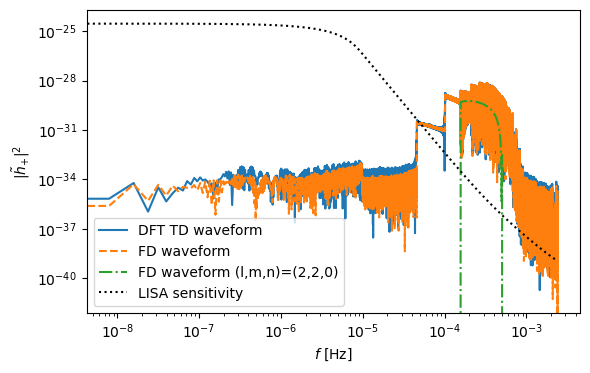

In [63]:
# FD plot
enlarge = 1.1
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2,label='DFT TD waveform')
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf[0].get())**2,'--',label='FD waveform')
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf_220[0].get())**2 ,'-.',label='FD waveform (l,m,n)=(2,2,0)',)
    plt.loglog(freq[positive_frequency_mask].get(), get_sensitivity(freq[positive_frequency_mask].get()),'k:',label='LISA sensitivity')

else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2,label='TD')
    plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,label='FD')
plt.ylabel(r'$| \tilde{h}_{+}|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
# plt.ylim([1e-46, 1e-32])
# plt.savefig('figures/FD_TD_frequency.pdf')

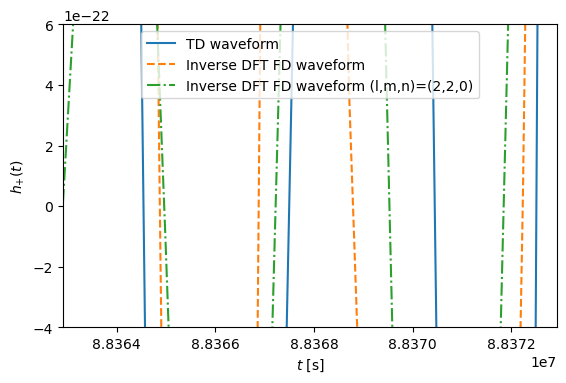

In [50]:
# TD plot
time_array = np.arange(0,len(data_channels_td[0]))*dt
ifft_fd = xp.fft.ifft(xp.append(hf[0],hf[0][::-1][:-1] )/dt)
ifft_fd_22 = xp.fft.ifft(xp.append(hf_220[0],xp.flip(hf_220[0][1:] ))/dt)


enlarge = 1.1
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))


if use_gpu:
    plt.plot(time_array, data_channels_td[0].get(),label='TD waveform')
    plt.plot(time_array, ifft_fd.get(),'--' ,label='Inverse DFT FD waveform')
    plt.plot(time_array, ifft_fd_22.get(),'-.' ,label='Inverse DFT FD waveform (l,m,n)=(2,2,0)')

else:
    plt.plot(time_array, data_channels_td[0],label='TD')
    plt.plot(time_array, ifft_fd,'--' ,label='FD')

plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 10e3
plt.xlim([t0,t0+space_t])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc='upper center')

plt.savefig('figures/FD_TD_time.pdf')

## Frequency downsampling

In [67]:

# list the indeces 
lst_ind = list(range(len(freq)))
upp = 50000
# make sure there is the zero frequency when you jump
check_vec = xp.asarray([1==xp.sum(freq[lst_ind[0::ii]]==0.0) for ii in range(2,upp)])
# find the one that has the zero frequency
ii = int(xp.arange(2,upp)[check_vec][-1])
print('--------------------------')
print('skip every ',ii, 'th element')
print('number of frequencies', len(freq[lst_ind[0::ii]]))
print('percentage of frequencies', len(freq[lst_ind[0::ii]])/len(freq))
# add f_arr to the kwarguments
if use_gpu:
    f_arr = freq[lst_ind[0::ii]][freq[lst_ind[0::ii]]>=0.0]
else:
    f_arr = freq[lst_ind[0::ii]][freq[lst_ind[0::ii]]>=0.0].get()

fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq[lst_ind[0::ii]]
fd_kwargs['mask_positive'] = True

positive_mask = (f_arr>=0.0)

--------------------------
skip every  48551 th element
number of frequencies 261
percentage of frequencies 2.0676115308080853e-05


{'T': 4.0,
 'dt': 10.0,
 'eps': 1e-05,
 'f_arr': array([-0.05      , -0.04961538, -0.04923077, -0.04884615, -0.04846153,
        -0.04807692, -0.0476923 , -0.04730769, -0.04692307, -0.04653846,
        -0.04615384, -0.04576923, -0.04538461, -0.045     , -0.04461538,
        -0.04423077, -0.04384615, -0.04346154, -0.04307692, -0.0426923 ,
        -0.04230769, -0.04192307, -0.04153846, -0.04115384, -0.04076923,
        -0.04038461, -0.04      , -0.03961538, -0.03923077, -0.03884615,
        -0.03846154, -0.03807692, -0.0376923 , -0.03730769, -0.03692307,
        -0.03653846, -0.03615384, -0.03576923, -0.03538461, -0.035     ,
        -0.03461538, -0.03423077, -0.03384615, -0.03346154, -0.03307692,
        -0.03269231, -0.03230769, -0.03192307, -0.03153846, -0.03115384,
        -0.03076923, -0.03038461, -0.03      , -0.02961538, -0.02923077,
        -0.02884615, -0.02846154, -0.02807692, -0.02769231, -0.02730769,
        -0.02692307, -0.02653846, -0.02615384, -0.02576923, -0.02538461,
   

In [68]:
# generate wave
tic = time.time()
tmp_hf = few_gen(*emri_injection_params, **fd_kwargs)
toc = time.time()
print('timing ', toc - tic)

fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=f_arr)

Mism = np.abs(1-inner_product(tmp_hf[0], hf[0][0::ii][positive_mask], normalize=True, **fd_inner_product_kwargs))
print('mimsatch = ',Mism)

timing  0.03690361976623535
mimsatch =  0.0


In [69]:
# FD plot
plt.figure()
# if use_gpu:
plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf[0].get())**2,label='FD')
plt.loglog(f_arr[positive_mask].get(), np.abs(tmp_hf[0][positive_mask].get())**2,label='FD downsampled')
# else:
#     plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2,label='TD')
#     plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,label='FD')
plt.ylabel(r'$| \tilde{h}_{+}|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

## Mass invariance

In [70]:
list_h = []
list_f = []
T = 4.0
dt = 10.0
Mvec = 10**np.linspace(5.0,6.5,num=3)

for M in Mvec:

    # fix mass ratio
    mu = 5e-5*M

    # rescale time
    Tnew = T*(M/1e6)
    
    # generate wave
    list_h.append(
        few_gen(M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,
                T=10.0,dt=dt,mode_selection=[(2,2,0)],mask_positive=True)
    )

    # adimensionless frequency
    list_f.append(few_gen.waveform_generator.create_waveform.frequency * M * MTSUN_SI )
    

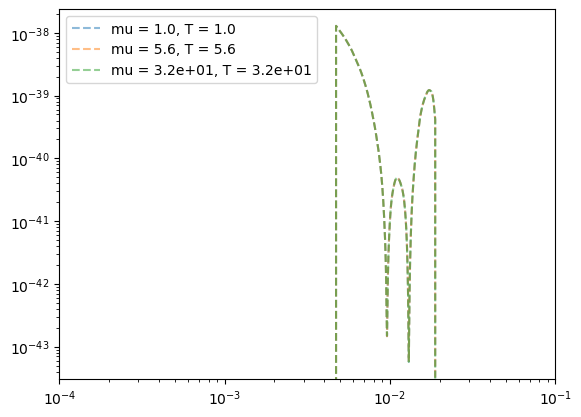

In [71]:
plt.figure()

for ii in range(len(Mvec)):
    Tnew = 10.0 * Mvec[ii] / 1e6
    tmp_mu = 1e-5 * Mvec[ii]
    
    ff = list_f[ii].get()
    ff = ff[ff>=0.0]
    h2 = np.abs(list_h[ii][0].get() / (tmp_mu * Tnew) )**2 
    plt.loglog(ff, h2,'--', label = f'mu = {tmp_mu:.2}, T = {Tnew:.2}',alpha=0.5)

plt.xlim([1e-4,1e-1])
plt.legend()
plt.show()

## Import results

In [73]:
files = ['results/emri_T4.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T4.0_seed2601996_dt10.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5',
'results/emri_T4.0_seed2601996_dt5.0_eps0.01_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T2.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5'
]

In [74]:
files

['results/emri_T4.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T4.0_seed2601996_dt10.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T4.0_seed2601996_dt5.0_eps0.01_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T2.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5']

In [40]:
# define variables
speed_td = []
speed_fd = []
speed_fd_downsampled = []
injection_pars = []
dt_T_eps = []
mismatch = []
# blackman, hann, nuttall
mismatch_windowed_b = []
mismatch_windowed_h = []
mismatch_windowed_n = []
mismatch_windowed = []
SNR = []

for ff in files:
    print("importing results from ",ff)
    dset = h5py.File(ff,'r')
    speed_td.append(dset['timing_td'][:5000])
    speed_fd.append(dset['timing_fd'][:5000,0])
    speed_fd_downsampled.append(dset['timing_fd'][:5000,1])
    
    SNR.append(dset['SNR'][:5000])
    injection_pars.append(dset['list_injections'][:5000])
    mismatch.append(dset['mismatch'][:5000,0])
    mismatch_windowed_b.append(dset['mismatch'][:5000,1])
    mismatch_windowed_h.append(dset['mismatch'][:5000,2])
    mismatch_windowed_n.append(dset['mismatch'][:5000,3])
    dt_T_eps.append([dset['dt'][...], dset['T'][...], dset['eps'][...] ])
    dset.close()

linest = ['-',':', '--', '-.',]


importing results from  results/emri_T4.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5
importing results from  results/emri_T4.0_seed2601996_dt10.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5
importing results from  results/emri_T4.0_seed2601996_dt5.0_eps0.01_fixedInsp1_tot_numb10000_newsens.h5
importing results from  results/emri_T2.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5


In [41]:
for ii in range(4):
    plt.loglog(mismatch_windowed_h[ii],speed_fd[ii],'.')
    print(np.corrcoef(mismatch_windowed_h[ii],speed_fd[ii])[0,1] )

-0.1058991610826372
-0.010037701414525146
-0.017432134792026866
-0.026534154818594304


In [43]:
speed_fd_downsampled[0].shape

(5000,)

median [1.3551724305260222, 1.0638856983731886, 0.8909406267921309, 1.2023531279084492]


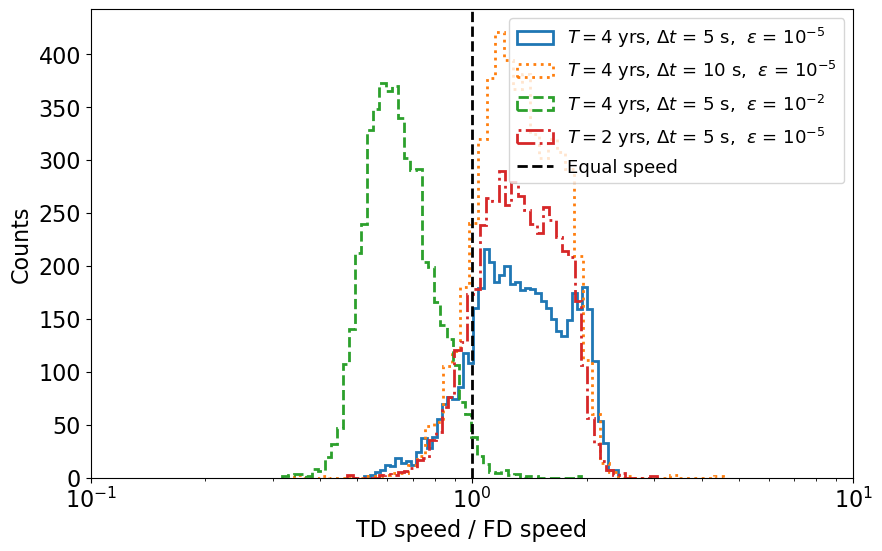

In [44]:
enlarge = 1.7
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(sptd/spfd, bins=np.logspace(np.log10((sptd/spfd).min()),np.log10((sptd/spfd).max())),
          linewidth=2.0,linestyle=ls,
          histtype='step', label=f'$T = {int(el[1])}$ yrs, $\Delta t$ = {int(el[0])} s,  $\epsilon$ = ${as_si(el[2],0)}$',density=False)
 for spfd,sptd,el,ls in zip(speed_fd_downsampled,speed_td,dt_T_eps,linest)]

plt.axvline(1.0,color='k',label='Equal speed',linestyle='--',linewidth=2.0,)
plt.xlabel('TD speed / FD speed',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.legend(loc='upper right',fontsize=13)
plt.semilogx()
plt.xlim([1e-1, 10])
plt.tick_params(axis='both', labelsize=16)

plt.savefig('figures/speed_different_systems_downsampled.pdf')

print("median",[np.quantile(sptd/spfd,0.5) for spfd,sptd,el in zip(speed_fd,speed_td,dt_T_eps)])


In [45]:
enlarge = 1.35
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(speed,histtype='step', 
          bins=np.logspace(np.log10((speed).min()),np.log10((speed).max())), 
#         bins=np.logspace(-7,-2), 
          label=f'$T = {int(el[1])}$ yrs, $\Delta t$ = {int(el[0])} s, $\epsilon$ = ${as_si(el[2],0)}$',density=False,
          linewidth=2.0, linestyle=ls) 
         for speed,el,ls in zip(mismatch_windowed_h,dt_T_eps,linest)]
print([np.log10(speed.min())       for speed,el,ls in zip(mismatch_windowed_h,dt_T_eps,linest)])
# plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel('Counts')
# plt.yticks([])
plt.legend()
plt.semilogx()
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,8))
# plt.tight_layout()
plt.savefig('figures/mismatch_different_systems_windowed_hann.pdf')


[-6.497710448863318, -6.838389602883775, -6.497813456427775, -6.741589354498262]


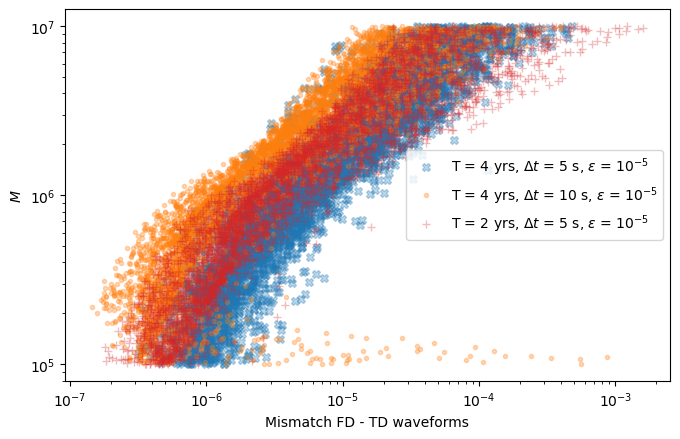

In [46]:
lab = ['$M$', '$\mu$', ' ','$p_0$','$e_0$', ]

var = 0
mark = ['X','.','o','+']
cmap = plt.cm.get_cmap('tab10')

enlarge = 1.35
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.loglog(mismatch_windowed_h[ii],injection_pars[ii][:,var],mark[ii],color=cmap(ii),
            label=f'T = {int(dt_T_eps[ii][1])} yrs, $\Delta t$ = {int(dt_T_eps[ii][0])} s, $\epsilon$ = ${as_si(dt_T_eps[ii][2],0)}$',alpha=0.3) for ii in [0,1,3]]
plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel(lab[var])
plt.legend()
plt.savefig('figures/mismatch_mass_different_systems_windowed_hann.pdf')



(2.8284271247461903, 2.637717372816083)

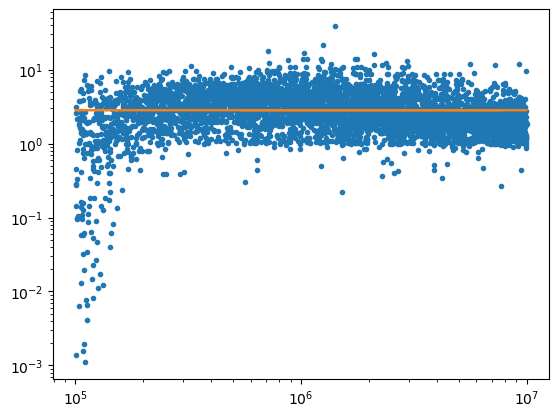

In [47]:
plt.loglog(injection_pars[0][:,var],(mismatch_windowed_h[0]/mismatch_windowed_h[1]),'.')
# plt.loglog(injection_pars[0][:,var],2*np.ones_like(injection_pars[0][:,var]),'-')

plt.loglog(injection_pars[0][:,var],2*np.sqrt(2)*np.ones_like(injection_pars[0][:,var]),'-')
2*np.sqrt(2),np.median((mismatch_windowed_h[0]/mismatch_windowed_h[1])[injection_pars[0][:,0]>3e5] )

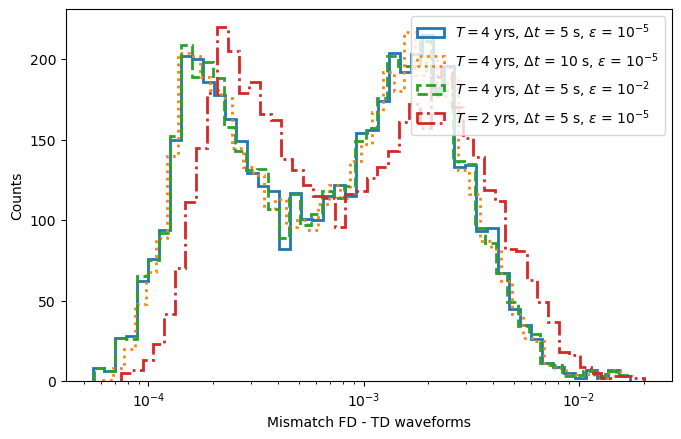

In [48]:

plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(speed,histtype='step', 
          bins=np.logspace(np.log10((speed).min()),np.log10((speed).max())), 

          label=f'$T = {int(el[1])}$ yrs, $\Delta t$ = {int(el[0])} s, $\epsilon$ = ${as_si(el[2],0)}$',density=False,
          linewidth=2.0, linestyle=ls) 
         for speed,el,ls in zip(mismatch,dt_T_eps,linest)]

plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel('Counts')
# plt.yticks([])
plt.legend()
plt.semilogx()
# plt.tight_layout()
plt.savefig('figures/mismatch_different_systems_nowindowed.pdf')

In [49]:
print("95 %",[np.quantile(speed,0.95) for speed,el in zip(mismatch_windowed_h,dt_T_eps)])
print("medians",[np.quantile(speed,0.5) for speed,el in zip(mismatch_windowed_h,dt_T_eps)])

95 % [7.78422790154776e-05, 4.1386006036464615e-05, 7.433787577475483e-05, 9.743289071686985e-05]
medians [7.719051220544948e-06, 2.8893325352274957e-06, 7.585231295903494e-06, 4.087138271657853e-06]


[]

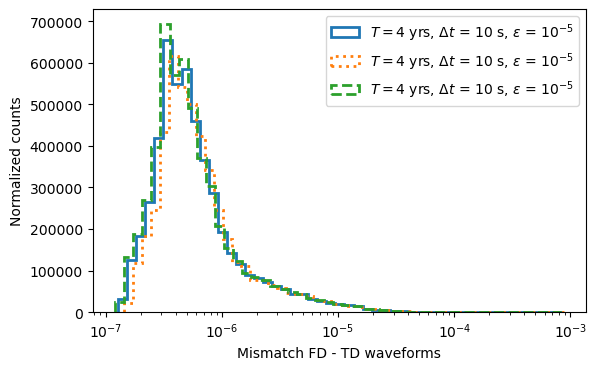

In [50]:
ii=1
enlarge = 1.1
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(speed,histtype='step', bins=np.logspace(np.log10((speed).min()),np.log10((speed).max())), 
          label=f'$T = {int(dt_T_eps[ii][1])}$ yrs, $\Delta t$ = {int(dt_T_eps[ii][0])} s, $\epsilon$ = ${as_si(dt_T_eps[ii][2],0)}$',density=True,
          linewidth=2.0, linestyle=ls) 
         for speed,ls in zip([mismatch_windowed_b[ii],mismatch_windowed_h[ii], mismatch_windowed_n[ii]],linest)]

plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel('Normalized counts')
# plt.yticks([])
plt.legend()
plt.semilogx()
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,8))
# plt.tight_layout()
# plt.savefig('figures/mismatch_different_systems_windowed_hann.pdf')



In [51]:
SNR

[array([[17.34518411,  9.02324872, 10.05594762,  8.33461408],
        [ 9.80879519,  5.21684013,  5.80441316,  4.82336674],
        [37.37947644, 18.03300755, 20.18607067, 16.61408994],
        ...,
        [ 4.50408409,  2.40864138,  2.67911291,  2.22729455],
        [14.5760258 ,  7.67564953,  8.54507429,  7.09437996],
        [65.61321389, 30.97449026, 34.70062844, 28.52464396]]),
 array([[17.34519545,  9.02324869, 10.05595122,  8.33461142],
        [ 9.80930421,  5.21729418,  5.80483663,  4.82385225],
        [37.37868021, 18.03216299, 20.18504135, 16.6133941 ],
        ...,
        [ 4.50457354,  2.40836465,  2.67889516,  2.22699642],
        [14.5760252 ,  7.67567223,  8.54509694,  7.09440127],
        [65.61286665, 30.97301496, 34.69915751, 28.52317526]]),
 array([[16.38124082,  8.53833694,  9.51451059,  7.88717006],
        [ 9.05085955,  4.81434001,  5.35643786,  4.45130152],
        [34.82563792, 16.82160124, 18.82829517, 15.49897513],
        ...,
        [ 4.20358699,  2.25

[]

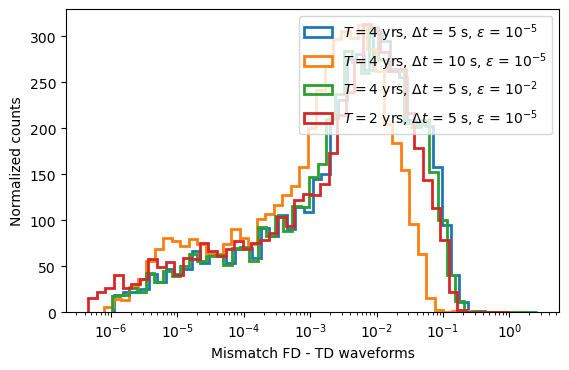

In [52]:
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(speed*snr[:,2]**2,histtype='step', bins=np.logspace(np.log10((speed*snr[:,0]**2).min()),np.log10((speed*snr[:,0]**2).max())), 
          label=f'$T = {int(el[1])}$ yrs, $\Delta t$ = {int(el[0])} s, $\epsilon$ = ${as_si(el[2],0)}$',density=False,
          linewidth=2.0, linestyle='-') 
         for speed,el,snr in zip(mismatch_windowed_h,dt_T_eps,SNR)]

plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel('Normalized counts')
plt.legend()
plt.semilogx()

In [53]:
var=0
ii=2
for var in [0,1,3,4]:
    print(np.corrcoef([injection_pars[ii][:,var], speed_td[ii]/speed_fd[ii]])[0,1] )

0.3731186944024771
0.21991936739308787
-0.3270543318593017
0.2403529349057511


In [54]:


plt.figure()
[plt.hist(np.log10(injection_pars[ii][:,var]),histtype='step', label=f'T={dt_T_eps[ii][1]} yrs, dt = {dt_T_eps[ii][0]}, eps = {dt_T_eps[ii][2]}') for ii in [0,1, 3]]
plt.ylabel('Mismatch')
plt.xlabel(lab[var])
plt.legend()
plt.show()



In [55]:
injection_pars[0][:,var].min(), injection_pars[0][:,var].max()

(0.001377591524378195, 0.6999053451887983)

In [56]:
var=0
for var in [0,1,3,4]:
    print(np.corrcoef([injection_pars[ii][:,var], mismatch_windowed_h[ii]])[0,1] )

0.739190972391082
0.25551808580154156
-0.4344676226923886
-0.10162497251519875


In [57]:
ii = 3
# Generate random data
x = injection_pars[ii][:,0]#injection_pars[ii][:,1]/injection_pars[ii][:,0]
omega = (injection_pars[ii][:,3]/(1-injection_pars[ii][:,4]**2))**(-3/2)/(2*np.pi*MTSUN_SI*injection_pars[ii][:,0])
y = omega#
z = mismatch_windowed_h[ii]#speed_td[ii]/speed_fd[ii]

# Define color scheme
cmap = plt.get_cmap('seismic')
colors = cmap(z)

enlarge = 1.2
# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
plt.title(f'T = {int(dt_T_eps[ii][1])} yrs, $\epsilon$ = ${as_si(dt_T_eps[ii][2],0)}$ , $\Delta t$ = {int(dt_T_eps[ii][0])} s')

plt.scatter(x, y, c=z, cmap=cmap, norm=matplotlib.colors.LogNorm(),alpha=0.8)
plt.colorbar(label='Mismatch FD - TD waveforms')
# plt.colorbar(label='log10 Mismatch')

# Set axis labels and title
ax.set_xlabel('$\mu/M$')
ax.set_ylabel('$M$')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
# plt.tight_layout()
plt.savefig('figures/mass_massratio_mismatch.pdf')

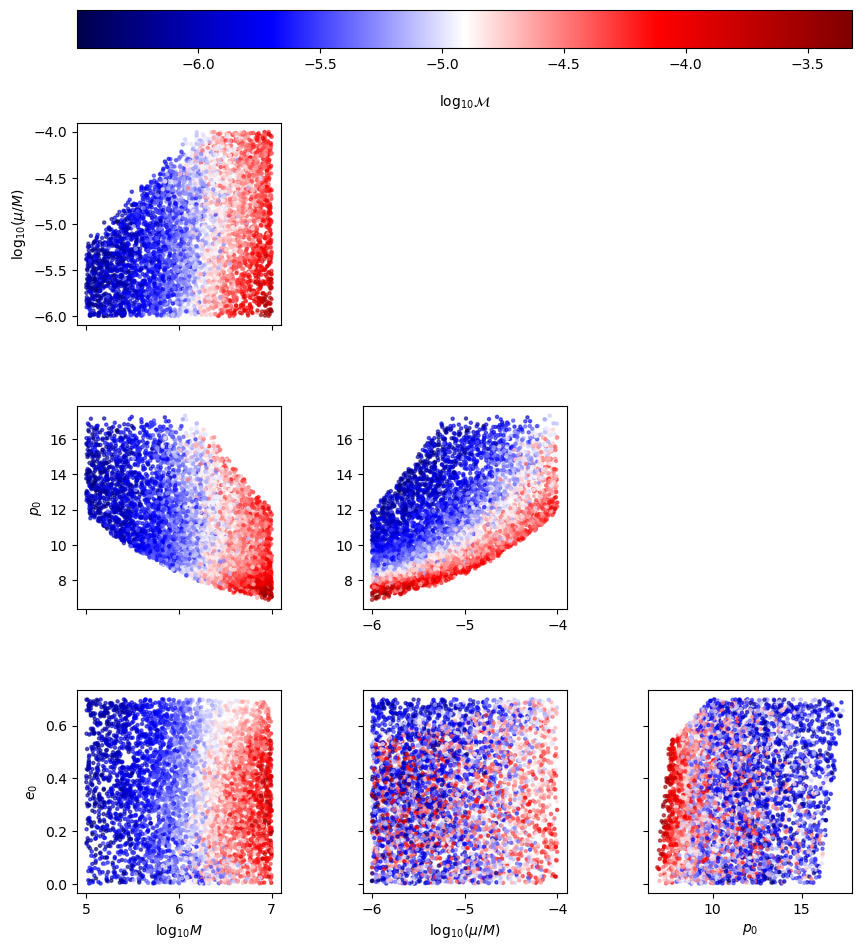

-6.497710448863318 -3.3172766182507676


-6.741589354498262 -2.8001239693843747


In [59]:
ii = 0
data_in = injection_pars[ii][:,[0,1,3,4]]
data_in[:,1] = np.log10(data_in[:,1]/data_in[:,0])
data_in[:,0] = np.log10(data_in[:,0])
get_colorplot(data_in, np.log10(mismatch_windowed_h[ii]),  ['$\log_{10}M$', '$\log_{10}(\mu/M)$','$p_0$','$e_0$'],'$\log_{10} \mathcal{M}$')
print(np.log10(mismatch_windowed_h[ii]).min(), np.log10(mismatch_windowed_h[ii]).max())

ii = 3
data_in = injection_pars[ii][:,[0,1,3,4]]
data_in[:,1] = np.log10(data_in[:,1]/data_in[:,0])
data_in[:,0] = np.log10(data_in[:,0])
get_colorplot(data_in, np.log10(mismatch_windowed_h[ii]),  ['$\log_{10}M$', '$\log_{10}(\mu/M)$','$p_0$','$e_0$'],'$\log_{10} \mathcal{M}$')
print(np.log10(mismatch_windowed_h[ii]).min(), np.log10(mismatch_windowed_h[ii]).max())


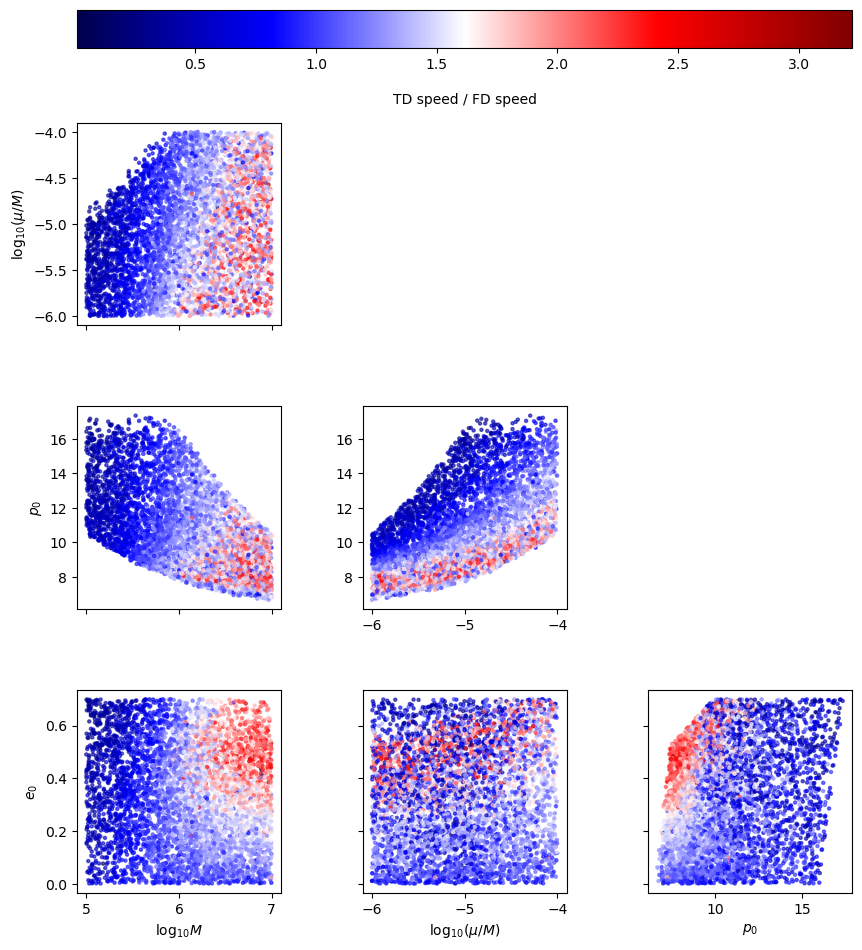

In [60]:
get_colorplot(data_in, speed_td[ii]/speed_fd[ii],  ['$\log_{10}M$', '$\log_{10}(\mu/M)$','$p_0$','$e_0$'],'TD speed / FD speed')

## Worst point in parameter space

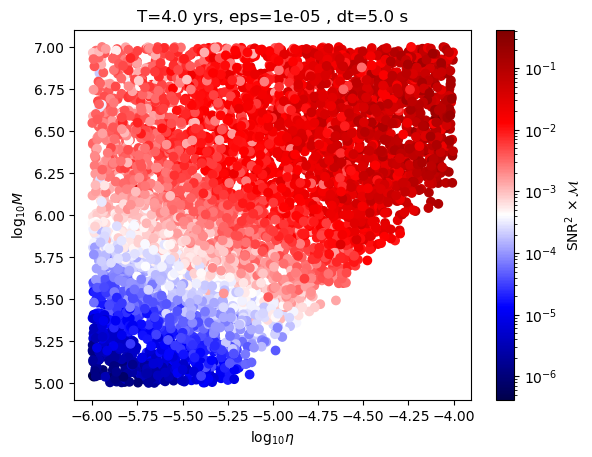

In [92]:
ii = 0
# Generate random data
x = np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0])
y = np.log10(injection_pars[ii][:,0])
z = SNR[ii][:,2]**2 * mismatch_windowed_h[ii]#mismatch_windowed_h[ii] # 

# Define color scheme
cmap = plt.get_cmap('seismic')
colors = cmap(z)

# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots()
plt.title(f'T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')
plt.scatter(x, y, c=z, cmap=cmap, norm=matplotlib.colors.LogNorm())
plt.colorbar(label=r'SNR$^2 \, \times \mathcal{M}$')

# Set axis labels and title
ax.set_xlabel('$\log_{10} \eta$')
ax.set_ylabel('$\log_{10} M$')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
# plt.tight_layout()
plt.show()

In [93]:
# worst Mismatch times SNR^2
ind = np.argsort(z)[-1:]
print("parameters ",[el for el in injection_pars[ii][ind][0][[0,1,3,4]] ])
print("snr = ",SNR[ii][ind,2],"mismatch", mismatch_windowed_h[ii][ind] )
# worst Mismatch 
z = mismatch_windowed_h[ii]
ind = np.argsort(z)[-1:]
print("parameters ",[el for el in injection_pars[ii][ind][0][[0,1,3,4]] ])
print("snr = ",SNR[ii][ind,2],"mismatch", mismatch_windowed_h[ii][ind] )

parameters  [3670041.7362535275, 292.0583167470244, 13.709101864726545, 0.5794130830706371]
snr =  [81.76166353] mismatch [6.18900235e-05]
parameters  [9992906.141310893, 11.305529838590854, 7.060600096664631, 0.19801820863315006]
snr =  [2.25763117] mismatch [0.00048164]


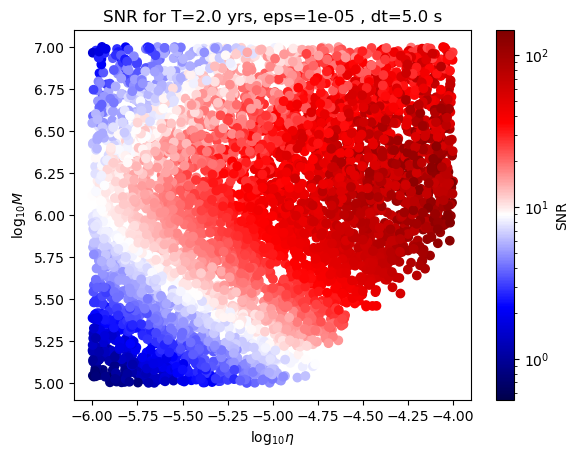

In [94]:
ii = 3
# Generate random data
x = np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0])
y = np.log10(injection_pars[ii][:,0])
z = SNR[ii][:,2]

# Define color scheme
cmap = plt.get_cmap('seismic')
colors = cmap(z)

# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots()
plt.title(f'SNR for T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')
plt.scatter(x, y, c=z, cmap=cmap, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='SNR')

# Set axis labels and title
ax.set_xlabel('$\log_{10} \eta$')
ax.set_ylabel('$\log_{10} M$')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
# plt.tight_layout()
plt.savefig('figures/mass_massratio_SNR.pdf')

# Speed analysis

In [75]:
# open dataset
dset = h5py.File("results/emri_T2.0_seed2601996_dt10.0_eps0.01_fixedInsp1_tot_numb1000_CPU_newsens.h5",'r')
speed_td_cpu = dset['timing_td'][:500]
speed_fd_cpu = dset['timing_fd'][:500,0]
speed_fd_downsampled_cpu = dset['timing_fd'][:500,1]
dt_T_eps_cpu = [dset['dt'][...], dset['T'][...], dset['eps'][...] ]
dset.close()

In [76]:
enlarge = 1.7
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(sptd/spfd, bins=np.logspace(np.log10((sptd/spfd).min()),np.log10((sptd/spfd).max())),
          linewidth=2.0,linestyle=ls,
          histtype='step', label=f'$T = {int(el[1])}$ yrs, $\Delta t$ = {int(el[0])} s,  $\epsilon$ = ${as_si(el[2],0)}$',density=False)
 for spfd,sptd,el,ls in zip(speed_fd,speed_td,dt_T_eps,linest)]

plt.axvline(1.0,color='k',label='Equal speed',linestyle='--',linewidth=2.0,)
plt.xlabel('TD speed / FD speed',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.legend(loc='upper right',fontsize=13)
plt.semilogx()
plt.xlim([1e-1, 10])
plt.tick_params(axis='both', labelsize=16)

plt.savefig('figures/speed_different_systems.pdf')

print("median",[np.quantile(sptd/spfd,0.5) for spfd,sptd,el in zip(speed_fd,speed_td,dt_T_eps)])

median [1.3551724305260222, 1.0638856983731886, 0.8909406267921309, 1.2023531279084492]


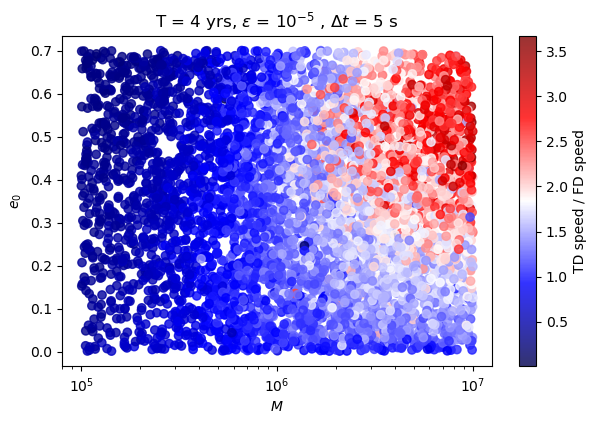

In [79]:
ii = 0
# Generate random data
x = injection_pars[ii][:,0]
y = injection_pars[ii][:,4]
z = speed_td[ii]/speed_fd[ii]

# Define color scheme
cmap = plt.get_cmap('seismic')
colors = cmap(z)

enlarge = 1.2
# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
plt.title(fr'T = {int(dt_T_eps[ii][1])} yrs, $\epsilon$ = ${as_si(dt_T_eps[ii][2],0)}$ , $\Delta t$ = {int(dt_T_eps[ii][0])} s')


plt.scatter(x, y, c=z, cmap=cmap,alpha=0.8)
plt.colorbar(label='TD speed / FD speed')
# plt.colorbar(label='log10 Mismatch')

# Set axis labels and title
ax.set_xlabel('$M$')
ax.set_ylabel('$e_0$')
# ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
# plt.tight_layout()
plt.savefig('figures/mass_ecc_speedup.pdf')

In [80]:
def find_regions(x, y, z, threshold):
    regions = []
    for i in range(len(x)):
        if (z[i] > threshold)and(z[i] < threshold*(1.05)):
            regions.append((x[i], y[i]))
    return regions

region = np.asarray(find_regions(x,y,z,1.0))

plt.figure()
plt.scatter(region[:,0], region[:,1],alpha=0.8)
plt.xlim([1e5,1e7])
plt.semilogx()

[]

## Posterior comparison

In [3]:
from eryn.backends import HDFBackend
import h5py, glob

In [4]:
def get_autocorr_plot(to_check):
    n_dim  = to_check.shape[-1]
    plt.figure()
    for var in range(n_dim):
        y = to_check[:,:,var].T
        # Compute the estimators for a few different chain lengths
        N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
        gw2010 = np.empty(len(N))
        new = np.empty(len(N))
        for i, n in enumerate(N):
            gw2010[i] = autocorr_gw2010(y[:, :n])
            new[i] = autocorr_new(y[:, :n])

        # Plot the comparisons
        # plt.loglog(N, gw2010, "o-", label="G&W 2010")
        plt.loglog(N, new, "o-", label=f"new var{var}")

    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    # plt.axhline(true_tau, color="k", label="truth", zorder=-100)
    plt.xlabel("number of samples, $N$")
    plt.ylabel(r"$\tau$ estimates")
    plt.legend(fontsize=14);
    plt.show()



In [7]:
datasets = glob.glob('results/newMCMC_emri_M3.7*.h5')
datasets
# samp.shape

['results/newMCMC_emri_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps1e-05_seed2601996_nw128_nt1_downsample0_injectFD0_templatetd.h5',
 'results/newMCMC_emri_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps1e-05_seed2601996_nw128_nt1_downsample0_injectFD0_templatefd.h5',
 'results/newMCMC_emri_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps1e-05_seed2601996_nw128_nt1_downsample0_injectFD1_templatefd.h5']

results/newMCMC_emri_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps1e-05_seed2601996_nw128_nt1_downsample0_injectFD0_templatetd.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.5065, 0.5164, 0.5065, 0.5067, 0.5129, 0.5029, 0.5097, 0.508 ,
        0.5005, 0.5031, 0.5085, 0.5178, 0.5205, 0.5052, 0.5176, 0.5121,
        0.5069, 0.5056, 0.5138, 0.5104, 0.5067, 0.5116, 0.5063, 0.5076,
        0.5152, 0.5118, 0.5062, 0.5046, 0.5061, 0.5062, 0.507 , 0.5021,
        0.5048, 0.5114, 0.5005, 0.5144, 0.5043, 0.5091, 0.5066, 0.5152,
        0.5142, 0.5141, 0.513 , 0.5147, 0.5043, 0.505 , 0.5212, 0.5069,
        0.5086, 0.513 , 0.5016, 0.5175, 0.508 , 0.5071, 0.5118, 0.5112,
        0.5059, 0.5104, 0.5123, 0.5051, 0.516 , 0.5075, 0.5101, 0.5105,
        0.5063, 0.5044, 0.5133, 0.5114, 0.5085, 0.5135, 0.5057, 0.5016,
        0.5113, 0.5041, 0.5032, 0.5058, 0.5112, 0.5097, 0.5144, 0.5088,
        0.4979, 0.5078, 0.5064, 0.5088, 0.5151, 0.5029, 0.5031, 0.5073,
        0.5148, 0.5106, 0.5078, 0.5077,

results/newMCMC_emri_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps1e-05_seed2601996_nw128_nt1_downsample0_injectFD0_templatefd.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.51106101, 0.51514725, 0.50866563, 0.51740172, 0.50683387,
        0.50993377, 0.50190221, 0.50528392, 0.51204734, 0.50951106,
        0.51472453, 0.51303368, 0.51275187, 0.49570241, 0.51035649,
        0.4985205 , 0.49654784, 0.51359729, 0.51218825, 0.51866986,
        0.52162886, 0.50274764, 0.50655206, 0.51331549, 0.50937016,
        0.50317035, 0.51824715, 0.51486544, 0.5047203 , 0.50782021,
        0.51303368, 0.5075384 , 0.50500211, 0.51092011, 0.49668874,
        0.50105678, 0.51049739, 0.51697901, 0.50035226, 0.50401578,
        0.51035649, 0.50852473, 0.50711568, 0.51007468, 0.50965197,
        0.5014795 , 0.51359729, 0.50584754, 0.51176553, 0.5047203 ,
        0.51007468, 0.50598845, 0.50105678, 0.50429759, 0.50824292,
        0.51796534, 0.50810201, 0.50782021, 0.50570664, 0.52331971,
        0.51049

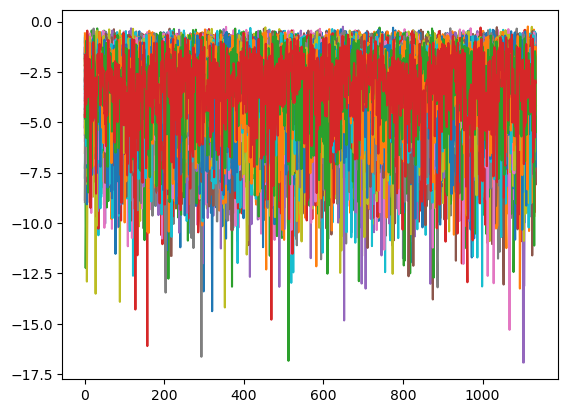

results/newMCMC_emri_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps1e-05_seed2601996_nw128_nt1_downsample0_injectFD1_templatefd.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.5011, 0.5082, 0.5109, 0.5105, 0.5152, 0.5114, 0.5038, 0.5025,
        0.5093, 0.5128, 0.5084, 0.5079, 0.5098, 0.5091, 0.5091, 0.5004,
        0.5004, 0.5077, 0.5143, 0.5025, 0.5097, 0.4977, 0.5147, 0.5019,
        0.5113, 0.5138, 0.5112, 0.5101, 0.5057, 0.4954, 0.5131, 0.5134,
        0.498 , 0.5089, 0.5117, 0.5117, 0.5043, 0.508 , 0.5056, 0.5115,
        0.5095, 0.5094, 0.512 , 0.5056, 0.5115, 0.4986, 0.5015, 0.5034,
        0.5151, 0.5063, 0.504 , 0.5142, 0.4962, 0.5013, 0.5198, 0.5074,
        0.5148, 0.4983, 0.5025, 0.5123, 0.5097, 0.5022, 0.504 , 0.5021,
        0.5059, 0.5114, 0.5084, 0.5079, 0.5149, 0.5096, 0.5075, 0.5108,
        0.5127, 0.5069, 0.5132, 0.5055, 0.5051, 0.5086, 0.5137, 0.5051,
        0.5079, 0.5038, 0.5009, 0.5132, 0.509 , 0.5044, 0.5051, 0.5116,
        0.5065, 0.5086, 0.4991, 0.5148,

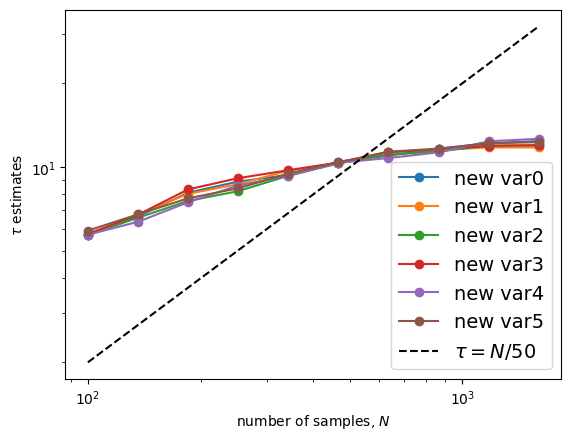

In [111]:
# filename = 'emri_M1e+06_mu1e+01_p9.5_e0.35_T1.0_eps1e-05_seed2601996_injectFD1_templatefd.h5'
temp=0

samp_final = []
for filename in datasets:
    file  = HDFBackend(filename)
    print(filename)
    print(file.get_move_info())
    max_iter = file.iteration
    burn = int(max_iter*0.2)
    thin = 5
    ll = file.get_log_like(discard=burn, thin=thin)
    mask = np.arange(64)#[file.get_move_info()['StretchMove_0']['acceptance_fraction'][0]>0.1]
    plt.figure()
    [plt.plot(ll[:,temp,walker],'-',label=f'{walker}') for walker in mask]
    plt.show()
    
    # get samples
    samp = file.get_chain(discard=burn, thin=thin)['emri'][:,temp,mask,...]
    get_autocorr_plot(samp[:,:,0,:])
    logl = ll[:,temp,mask,...]

    inds = file.get_inds(discard=burn, thin=thin)['emri']
    samp_final.append( np.hstack((samp[inds[:,temp,mask,...]],logl[inds[:,temp,mask,0],None])) )

In [112]:
# samp_final[0]
# np.asarray([np.append(el[0],el[1]) for el in samp_final])

In [113]:
M,mu,p0,e0 = 3670041.7362535275, 292.0583167470244, 13.709101864726545, 0.5794130830706371
Phi_phi0 = np.pi/3
Phi_r0 = np.pi/3

truths = [
            np.log(M),  
            np.log(mu/M),
            p0,
            e0,
            Phi_phi0, 
            Phi_r0,
                0.0
        ]

CORNER_KWARGS = dict(
#     smooth=0.6,
    labels=[r'$\log M$', r'$\log (\mu / M)$', r'$p_0$', r'$e_0$', 
#             r'$D_L$',
#             r'$\cos{\theta_K}$', r'$\phi_K$',
#            r'$\cos{\theta_S}$', r'$\phi_S$',
           r'$\Phi_{\phi 0}$', r'$\Phi_{r 0}$','Log-Likelihood'
           ],
    bins=40,
    truths = truths,
    label_kwargs=dict(fontsize=13),
    title_kwargs=dict(fontsize=13),
#     quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=7,
    truth_color='k'
)
import matplotlib.lines as mlines

def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)


def overlaid_corner(samples_list, sample_labels, name_save=None, corn_kw=CORNER_KWARGS):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('Set1',)
    colors = [cmap(i) for i in range(n)]#['black','red', 'royalblue']#

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)
    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        weights=get_normalisation_weight(len(samples_list[0]), max_len),
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=25, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
#     fig.subplots_adjust(right=1.0,top=1.0)

    plt.subplots_adjust(left=-0.1, bottom=-0.1, right=None, top=None, wspace=None, hspace=0.15)

    if name_save is not None:
        plt.savefig(name_save+".pdf", pad_inches=0.2, bbox_inches='tight')
    else:
        plt.show()


In [114]:
# plt.savefig?

In [115]:
name_mcmc = [el.split('downsample0_')[-1].split('.h5')[0] for el in datasets]
name_mcmc

['injectFD0_templatetd', 'injectFD0_templatefd', 'injectFD1_templatefd']

In [116]:
samp_final[0].shape

(102400, 7)

In [117]:
name_mcmc

['injectFD0_templatetd', 'injectFD0_templatefd', 'injectFD1_templatefd']

In [118]:
name_mcmc = ['TD injection, FD template',
            'TD injection, TD template',
             'FD injection, FD template',
            ]

In [119]:
overlaid_corner(samp_final, name_mcmc, name_save='figures/posterior_comparison_intrinsic')

In [363]:
# np.save("covariance.npy",np.cov(samp_final[2].T))

In [19]:
# np.save("samples_to_test",samp_final[0][-5000:])

In [33]:
np.save("covariance.npy",samp_final[0][:,:-1])